## Import Library

In [1]:
import dgl
import torch
import itertools
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn.pytorch import conv as dgl_conv
from startup_data_set import COMP4222Dataset_hetero
from PredictorClasses import *
from CustomMetrics import *
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cpu')

### Hypermeters

In [11]:
val_ratio = 0.1
test_ratio = 0.1

# Hyperparameters
n_hidden = 64
output_dim = 2

## Load Dataset

In [12]:
graph = COMP4222Dataset_hetero()[0]
graph = dgl.to_homogeneous(graph,ndata=['feat'],edata=['feat'])
graph

Graph(num_nodes=25446, num_edges=45621,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [13]:
in_feats = graph.ndata['feat'].shape[1]
in_feats

221

## Generate Postitve Graph and Negative Graph with Spliting

In [14]:
from CustomUtilities import generate_neg_graph, generate_pos_graph
train_g, train_pos_g, val_pos_g, test_pos_g = \
    generate_pos_graph(graph, val_ratio, test_ratio)

train_g

Graph(num_nodes=25446, num_edges=61943,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [15]:
train_neg_g, val_neg_g, test_neg_g = \
    generate_neg_graph(graph, val_ratio, test_ratio)

train_neg_g

Graph(num_nodes=25446, num_edges=36497,
      ndata_schemes={}
      edata_schemes={})

## Model Training

### Model Setup

In [19]:
from dgl.nn.pytorch import GraphConv


class VGAEModel(nn.Module):
    def __init__(self, in_dim, hidden1_dim, hidden2_dim):
        super(VGAEModel, self).__init__()
        self.in_dim = in_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim

        layers = [
            GraphConv(
                self.in_dim,
                self.hidden1_dim,
                activation=F.relu,
                allow_zero_in_degree=True,
            ),
            GraphConv(
                self.hidden1_dim,
                self.hidden2_dim,
                activation=lambda x: x,
                allow_zero_in_degree=True,
            ),
            GraphConv(
                self.hidden1_dim,
                self.hidden2_dim,
                activation=lambda x: x,
                allow_zero_in_degree=True,
            ),
        ]
        self.layers = nn.ModuleList(layers)

    def encoder(self, g, features):
        h = self.layers[0](g, features)
        self.mean = self.layers[1](g, h)
        self.log_std = self.layers[2](g, h)
        gaussian_noise = torch.randn(features.size(0), self.hidden2_dim).to(
            device
        )
        sampled_z = self.mean + gaussian_noise * torch.exp(self.log_std).to(
            device
        )
        return sampled_z

    def decoder(self, z):
        adj_rec = nn.ReLU()(torch.matmul(z, z.t()))
        return adj_rec

    def forward(self, g, features):
        z = self.encoder(g, features)
        adj_rec = self.decoder(z)
        return adj_rec

In [20]:
vgae_model = VGAEModel(
    in_feats,
    n_hidden,
    out_dim
)

pred = DotPredictor()

### Training Loop

In [21]:
import itertools

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0

optimizer = torch.optim.Adam(itertools.chain(vgae_model.parameters(), pred.parameters()), lr=0.01)

for e in range(500):
    # forward
    h = vgae_model(train_g, train_g.ndata['feat'].float())
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g, h)
    v_neg_score = pred(val_neg_g, h)
    v_loss = compute_loss(v_pos_score, v_neg_score)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 1 == 0:
        print('Epoch: {} \t\t\t Train loss: {} \t\t\t Val loss: {}'.format(e, loss, v_loss))


    # early stopping
    if len(val_loss) > 2 and val_loss[-1] > val_loss[-2]:
        stop += 1
    if stop >= 30:
        print("Early Stopped at Epoch {}".format(e))
        break


c:\Users\samue\anaconda3\envs\COMP4222\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 0 			 Train loss: 2334.108642578125 			 Val loss: 2379.6220703125


c:\Users\samue\anaconda3\envs\COMP4222\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 1 			 Train loss: 2062.086181640625 			 Val loss: 2065.811767578125


c:\Users\samue\anaconda3\envs\COMP4222\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 2 			 Train loss: 2036.9844970703125 			 Val loss: 2132.89892578125


c:\Users\samue\anaconda3\envs\COMP4222\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 3 			 Train loss: 2005.0572509765625 			 Val loss: 1998.8526611328125


c:\Users\samue\anaconda3\envs\COMP4222\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 4 			 Train loss: 1962.381591796875 			 Val loss: 2073.135009765625


KeyboardInterrupt: 

In [ ]:
# testing AUC
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.5281166820201035


### Result Plotting

In [ ]:

plt.plot(train_loss[10:])
plt.plot(val_loss[10:])

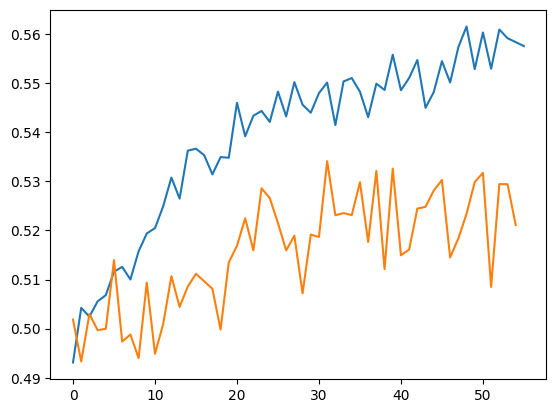

In [ ]:
plt.plot(train_AUC)
plt.plot(val_AUC)